In [1]:
import numpy as np 
from itertools import chain, combinations
from scipy.sparse import *
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# $\lambda_i^j$ i.i.d

In [2]:
def steady_state(Lambda, msg=None):
    n = len(Lambda)
    C = np.concatenate((Lambda[0:n-1,:] - Lambda[1:n,:], np.ones((1,n))), axis=0)
    det = np.linalg.det(C)
    if det == 0: 
        if msg : print('Encore du travail !')
        return []
    b = np.zeros((n,1))
    b[n-1] = 1
    Xsol = np.linalg.solve(C,b)
    if len(Xsol[Xsol < 0])>=1:
        if msg : print('Pas de solution positive')
        return []
    else : 
        if msg : print('Solution de coexistence')
        return Xsol

In [3]:
def classification_test(Lambda):
    """For the system defined by Lambda, 
    this function compute all the steady states.
    the output is 'steady' : the value of the steady state z
    """
    assert len(Lambda) != 0
    N = len(Lambda)
    SS = []
    
    for r in range(1, N + 1):
        for I in combinations(range(N), r):
            I = list(I)
            Lambdasub = np.zeros((len(I),len(I)))
            for i in range(len(I)):
                for j in range(len(I)):
                    Lambdasub[i,j] = Lambda[I[i],I[j]]
            zsub = steady_state(Lambdasub)
            if len(zsub) > 0:
                z = np.zeros((N,1))
                z[I] = zsub
                zs = z.reshape(N).tolist()
                SS.append(zs)
    return SS

In [4]:
def generate_matrix(N, mean=0, var=1):
    Lambda = np.random.normal(mean, np.sqrt(var), (N,N))
    np.fill_diagonal(Lambda, 0)
    return Lambda

In [8]:
M = 10000

In [9]:
N_values = range(2, 11)

## Average number of steady states

In [115]:
def av(M, N_values, mean=0, var=1):
    av_SS = []
    for N in N_values:
        S_Lambda = 0
        for _ in range(M):
            Lambda = generate_matrix(N, mean=0, var=1)
            SS = classification_test(Lambda)
            S_Lambda += len(SS)
        
        S_Lambda /= M
        av_SS.append(S_Lambda)
    plt.plot(N_values, av_SS, marker='o', linestyle='-', color='b')    
    plt.xlabel('N')
    plt.ylabel('Average number of steady states')
    plt.grid(True)
    plt.show()

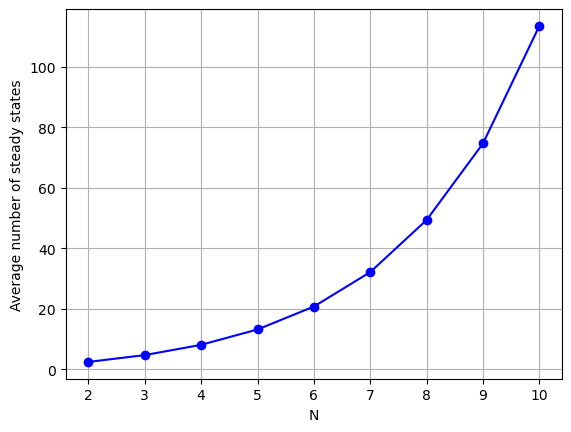

In [35]:
av(M, N_values, mean=0, var=1)

## Probability of having a steady state with k strains

In [5]:
def prop_k(N, mean=0, var=1):
    prop_k_SS = np.zeros(N)
    Lambda = generate_matrix(N, mean=0, var=1)
    SS = classification_test(Lambda)
    S_Lambda = len(SS)
    for i in range(S_Lambda):
        num_non_zeros = np.count_nonzero(SS[i])
        prop_k_SS[num_non_zeros-1] += 1
    prop_k_SS /= S_Lambda
    return prop_k_SS

In [6]:
def prop(M, N, mean=0, var=1):
    data = []
    for _ in range(M):
        prop_k_SS = prop_k(N, mean=0, var=1)
        data.append(prop_k_SS)
    data = np.array(data)
    return data

In [154]:
def histogram_prop(M, N, mean=0, var=1, alpha=0.05):
    data = prop(M, N, mean=0, var=1)
    m_k_strains = data.mean(axis=0)
    v_k_strains = data.var(axis=0)
    

    i = 0
    Mean = [0 for i in range(N)]
    for m, v in zip(m_k_strains, v_k_strains):
        i += 1
        m_v = v / M
        LCL, UCL = m + st.norm.isf([1 - alpha/2, alpha/2]) * np.sqrt(m_v)
        m = np.round(m, 3)
        v = np.round(v, 3)
        LCL = np.round(LCL, 3)
        UCL = np.round(UCL, 3)
        # print("Mean for %s strains: %s"%(i, m))
        # print("Variance for %s strains: %s"%(i, v))
        # print("0.95 confidence interval for %s strains: [%s, %s]"%(i, LCL, UCL))
        # print('\n')
        Mean[i-1] = m
        
    plt.bar(range(1, N+1), Mean)
    plt.xticks(range(1, N+1))
    plt.xlabel('k')
    plt.ylabel('Probability that a steady state has k strains')
    plt.title('N = %s'%N)
    plt.show()


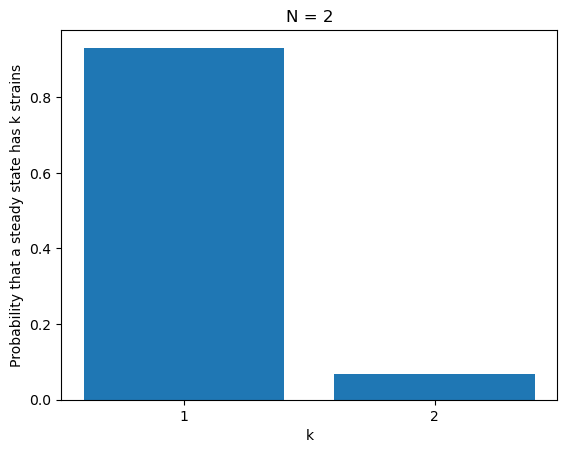

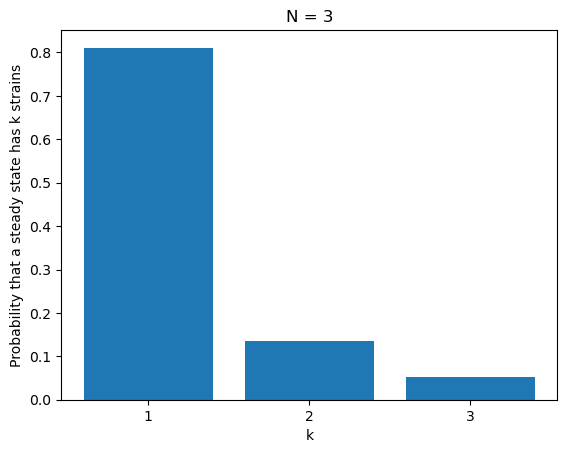

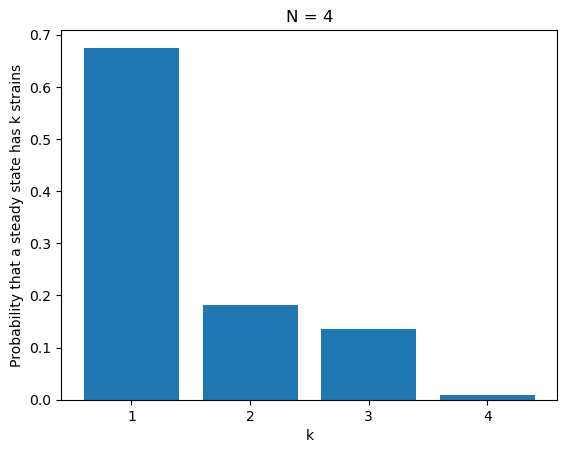

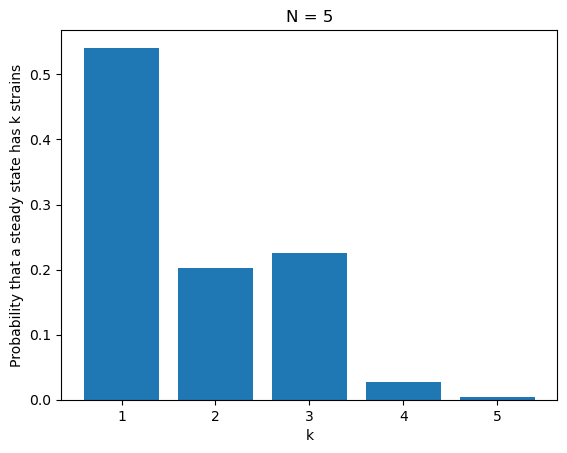

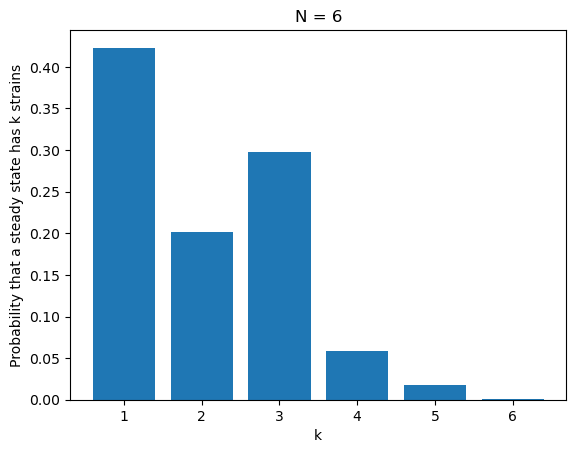

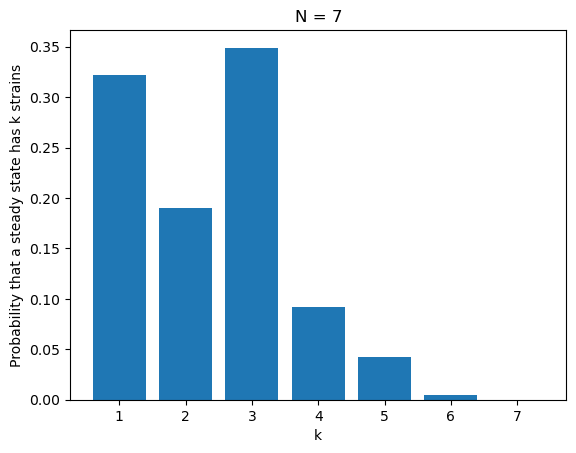

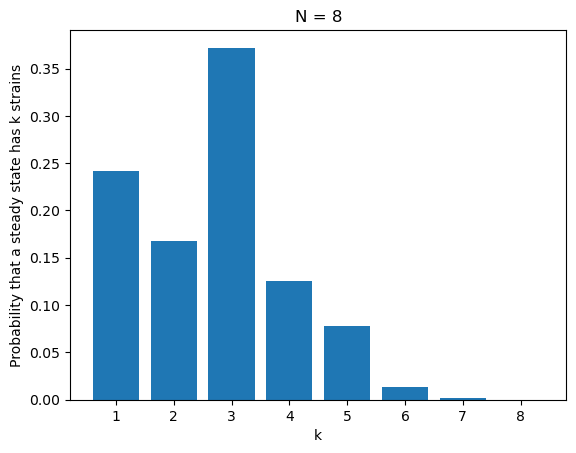

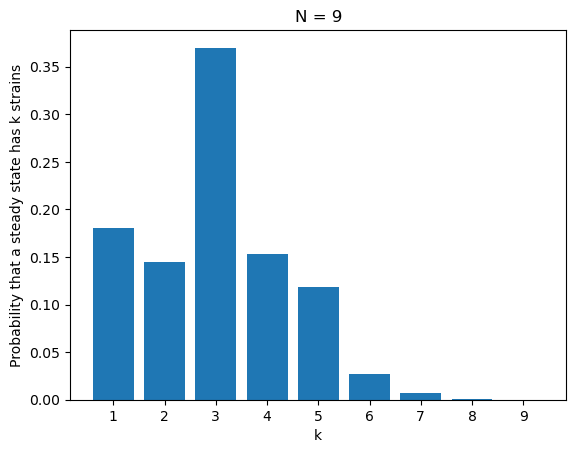

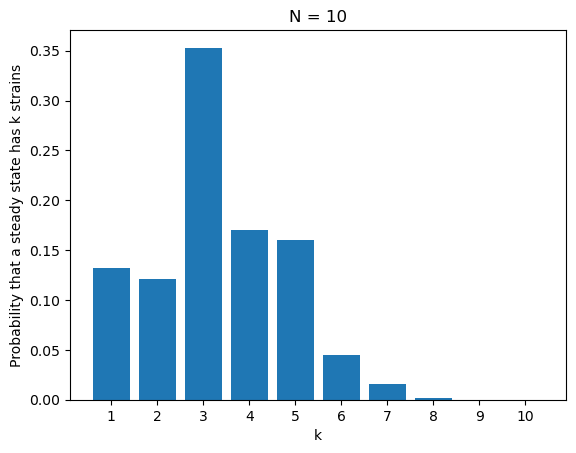

In [155]:
for N in range(2, 11):
    histogram_prop(10000, N, alpha=0.05)

In [13]:
def histogram_sub(M, N_values):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
    axs_flat = axs.flatten()
    
    for ax, N in zip(axs_flat, N_values):
        data = prop(M, N)
        m_k_strains = data.mean(axis=0)
        m_k_strains = np.insert(m_k_strains, 0, 0)
        ax.bar(range(0, N+1), m_k_strains)
        ax.set_xticks(range(0, N+1))
        ax.set_title(f'N={N}')
        
    fig.text(0.04, 0.5, 'Probability that a steady state has k strains', va='center', rotation='vertical')
    fig.text(0.5, 0.04, 'k', va='center', ha='center')
    plt.show()

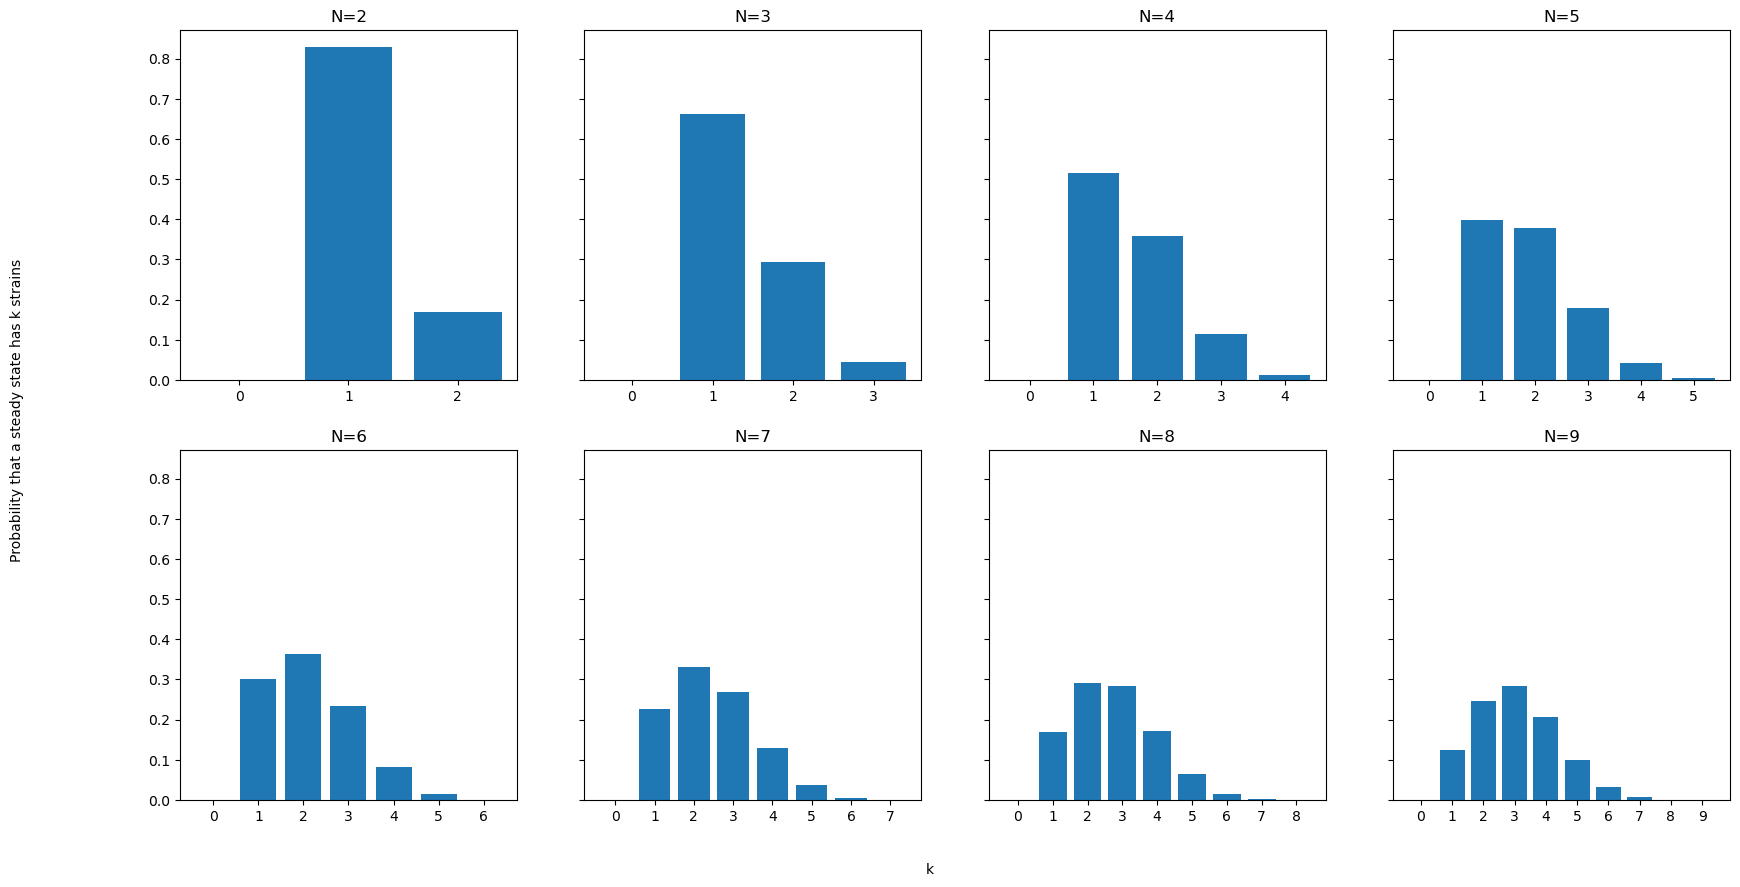

In [14]:
histogram_sub(M, N_values)

## Average of steady states with k strains

In [102]:
def exp_k(N, mean=0, var=1):
    Lambda = generate_matrix(N, mean=0, var=1)
    SS = classification_test(Lambda)
    exp_k_SS = np.zeros(N)
    S_Lambda = len(SS)
    for i in range(S_Lambda):
        num_non_zeros = np.count_nonzero(SS[i])
        exp_k_SS[num_non_zeros-1] += 1
    return exp_k_SS

In [103]:
def exp(M, N, mean=0, var=1):
    data = []
    for i in range(M):
        exp_k_SS = exp_k(N, mean=0, var=1)
        data.append(exp_k_SS)
    data = np.array(data)
    return data

In [131]:
def plot_exp_k(M, N_values, mean=0, var=1, alpha=0.05):
    assert len(N_values) >= 5
    plot_E = []
    for N in N_values:
        data = exp(M, N, mean=0, var=1)
        m_k_strains = data.mean(axis=0)
        v_k_strains = data.var(axis=0)
        i = 0
        Mean = np.zeros(len(N_values)+1)
        for m, v in zip(m_k_strains, v_k_strains):
            i += 1
            m_v = v / M
            LCL, UCL = m + st.norm.isf([1 - alpha/2, alpha/2]) * np.sqrt(m_v)
            m = np.round(m, 3)
            v = np.round(v, 3)
            LCL = np.round(LCL, 3)
            UCL = np.round(UCL, 3)
            # print("Mean for %s strains: %s"%(i, m))
            # print("Variance for %s strains: %s"%(i, v))
            # print("0.95 confidence interval for %s strains: [%s, %s]"%(i, LCL, UCL))
            # print('\n')
            Mean[i-1] = m
        plot_E.append(Mean)
    plot_E = np.array(plot_E)
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    for k in range(5):
        plt.plot(N_values, plot_E[:, k], color=colors[k], label=f'k={k+1}')
    plt.ylabel('Average of steady states with k strains')
    plt.xlabel('N')
    plt.legend()
    plt.grid(True)
    plt.show()

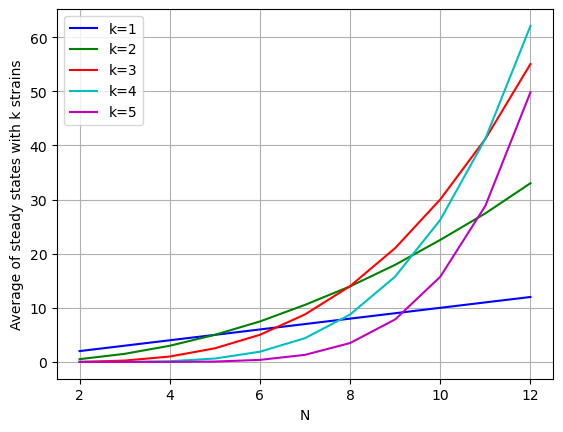

In [132]:
N_values = range(2,13)
plot_exp_k(M, N_values, mean=0, var=1, alpha=0.05)

# $\lambda_i^j = \alpha_{ji} - \alpha_{jj} - \mu (\alpha_{ij} - \alpha_{ji})$

In [25]:
def steady_state(A,mu=1,msg=None):
    """Computation of the steady_states of the reducted model.
    A is the matrix of interaction and mu is the ratio I/II
    """
    n=len(A)
    mat=mu*(A.T-A)+A.T
    C=np.concatenate( (mat[0:n-1,:]-mat[1:n,:],np.ones((1,n))), axis=0)
    det=np.linalg.det(C)
    if det==0: 
        if msg : print('Encore du travail !')
        return None 
    b=np.zeros((n,1))
    b[n-1]=1
    Xsol=np.linalg.solve(C,b)
    if len(Xsol[Xsol<0])>=1:
        if msg : print('Pas de solution positive')
        return []
    else : 
        if msg : print('Solution de coexistence')
        return Xsol

In [26]:
def fitness(A,mu=1):
    """Computation of the fitness of the reducted model.
    A is the matrix of interaction and mu is the ratio I/II
    """
    n=len(A)
    return mu*(A.T-A)+A.T-np.matrix(np.ones((n,1)))*np.matrix(np.diagonal(A))


In [27]:
def steady_state_fit(FIT,msg=None):
    """Computation of the steady_state using the fitness
    """
    n=len(FIT)        
    C=np.concatenate((np.ones((1,n)),(FIT[0:n-1,:]-FIT[1:n,:])), axis=0)
    det=np.linalg.det(C)
    if det==0: 
        if msg : print('Encore du travail !')
        return []
    b=np.zeros((n,1))
    b[0]=1
    Xsol=np.linalg.solve(C,b)
    if len(Xsol[Xsol<0])>=1:
        if msg : print('Pas de solution positive')
        return []
    else : 
        if msg : print('Solution de coexistence')
        return Xsol

In [28]:
def classification_test_mu(A=[],mu=1,FIT=[]):
    """For the system defined by Lambda, 
    this function compute all the steady states.
    the output is 'steady' : the value of the steady state z
    """
    
    assert len(A)+len(FIT)!=0
    if len(FIT)==0:
        FIT=fitness(A,mu)
    N=len(FIT)
    SS=[]

    for r in range(1, N + 1):
        for I in combinations(range(N), r):
            I = list(I)
            FITsub = np.zeros((len(I),len(I)))
            for i in range(len(I)):
                for j in range(len(I)):
                    FITsub[i,j] = FIT[I[i],I[j]]
            zsub = steady_state_fit(FITsub)
            if len(zsub) > 0:
                z = np.zeros((N,1))
                z[I] = zsub
                zs = z.reshape(N).tolist()
                SS.append(zs)
    return SS

In [29]:
def generate_A(N, mean=0, var=1):
    A = np.random.normal(mean, np.sqrt(var), (N,N))
    return A

In [30]:
M = 10000

In [31]:
N_values = range(2, 11)

In [32]:
mu_values = [0, 0.01, 0.1, 1, 10]

## Average number of steady states

In [131]:
def av_mu(M, N_values, mu_values, mean=0, var=1):
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    for i, mu in enumerate(mu_values):
        av_SS = []
        for N in N_values:
            S_Lambda = 0
            for _ in range(M):
                A = generate_A(N, mean=0, var=1)
                SS = classification_test_mu(A, mu)
                S_Lambda += len(SS)

            S_Lambda /= M
            av_SS.append(S_Lambda)
        plt.plot(N_values, av_SS, marker='o', linestyle='-', color=colors[i], label='$\mu=%s$'%mu)    
    plt.xlabel('N')
    plt.ylabel('Average number of steady states')
    plt.legend()
    plt.grid(True)
    plt.show()

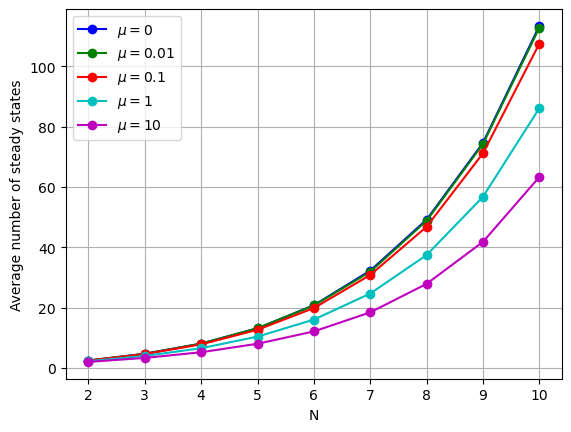

In [13]:
av_mu(M, N_values, mu_values, mean=0, var=1)

## Probability of having a steady state with k strains

In [15]:
def prop_k_mu(N, mu, mean=0, var=1):
    prop_k_SS = np.zeros(N)
    A = generate_A(N, mean=0, var=1)
    SS = classification_test_mu(A, mu)
    S_Lambda = len(SS)
    for i in range(S_Lambda):
        num_non_zeros = np.count_nonzero(SS[i])
        prop_k_SS[num_non_zeros-1] += 1
    prop_k_SS /= S_Lambda
    return prop_k_SS

In [16]:
def prop_mu(M, N, mu, mean=0, var=1):
    data = []
    for i in range(M):
        prop_k_SS = prop_k_mu(N, mu, mean=0, var=1)
        data.append(prop_k_SS)
    data = np.array(data)
    return data

In [17]:
def histogram_prop_mu(M, N, mu, mean=0, var=1, alpha=0.05):
    data = prop_mu(M, N, mu, mean=0, var=1)
    m_k_strains = data.mean(axis=0)
    print(m_k_strains)
    v_k_strains = data.var(axis=0)
    

    i = 0
    Mean = [0 for i in range(N)]
    for m, v in zip(m_k_strains, v_k_strains):
        i += 1
        m_v = v / M
        LCL, UCL = m + st.norm.isf([1 - alpha/2, alpha/2]) * np.sqrt(m_v)
        m = np.round(m, 3)
        v = np.round(v, 3)
        LCL = np.round(LCL, 3)
        UCL = np.round(UCL, 3)
        # print("Mean for %s strains: %s"%(i, m))
        # print("Variance for %s strains: %s"%(i, v))
        # print("0.95 confidence interval for %s strains: [%s, %s]"%(i, LCL, UCL))
        # print('\n')
        Mean[i-1] = m
        
    plt.bar(range(1, N+1), Mean)
    plt.xticks(range(1, N+1))
    plt.xlabel('k')
    plt.ylabel('Frequency of steady states with k strains')
    plt.title('N = %s'%N)
    plt.show()


In [149]:
def plot_cumulative(N, mu_values, M, mean=0, var=1):
    data = []
    for mu in mu_values:
        prop_data = prop_mu(M, N, mu, mean, var)
        m_k_strains = prop_data.mean(axis=0)
        data.append(m_k_strains)
    data = np.array(data)
    data = data.T
    fig, ax = plt.subplots()
    bar_width = 0.5
    x = np.arange(len(mu_values))
    bottom = np.zeros(len(mu_values))
    for k in range(N):
        ax.bar(x, data[k], bar_width, bottom=bottom, label=f'k = {k+1}')
        bottom += data[k]

    ax.set_xlabel('$\mu$')
    ax.set_ylabel('Probability that a steady state has k strains')
    ax.set_title(f'N = {N}')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{mu}' for mu in mu_values])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

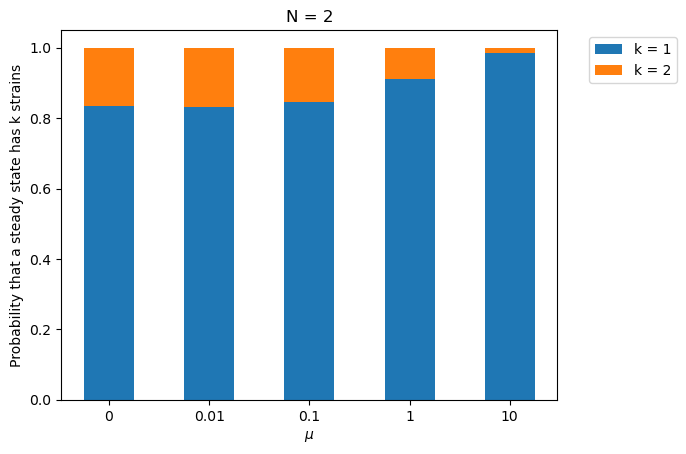

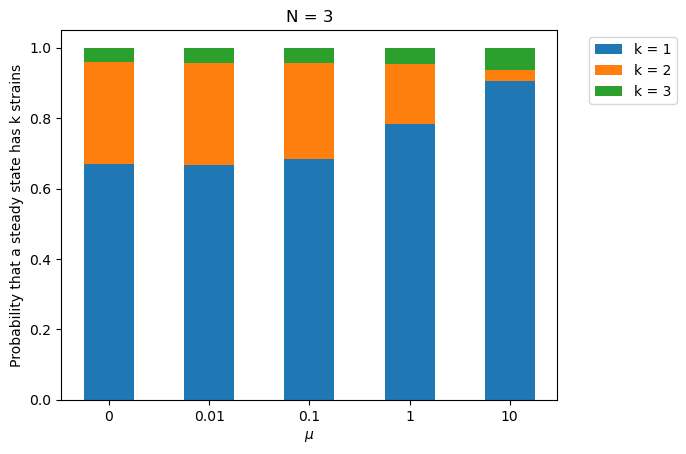

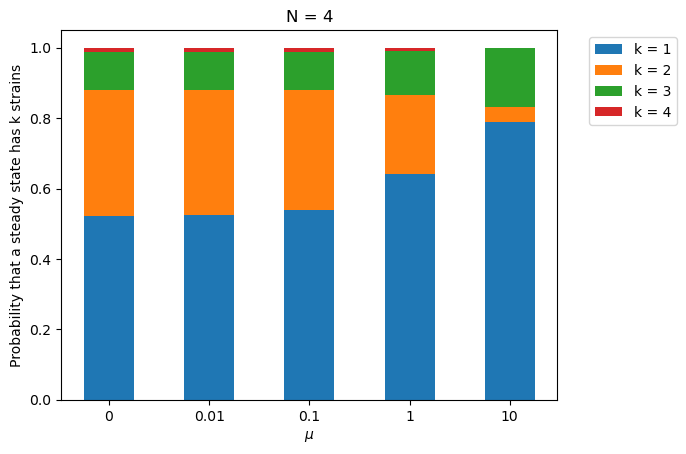

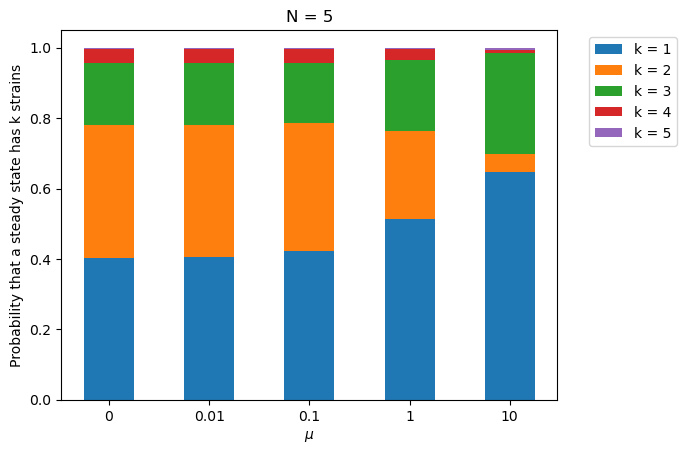

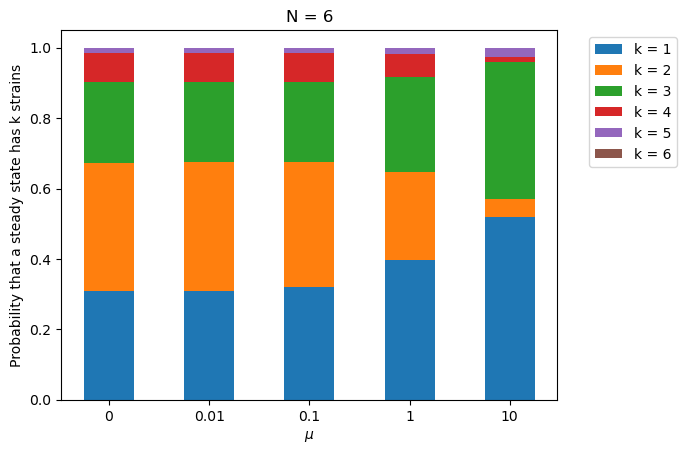

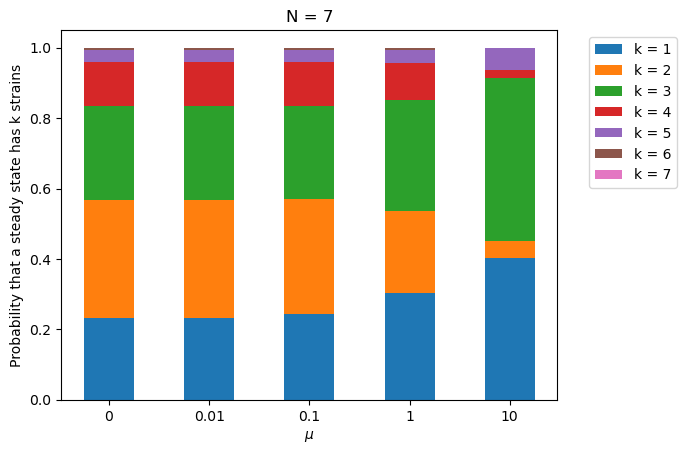

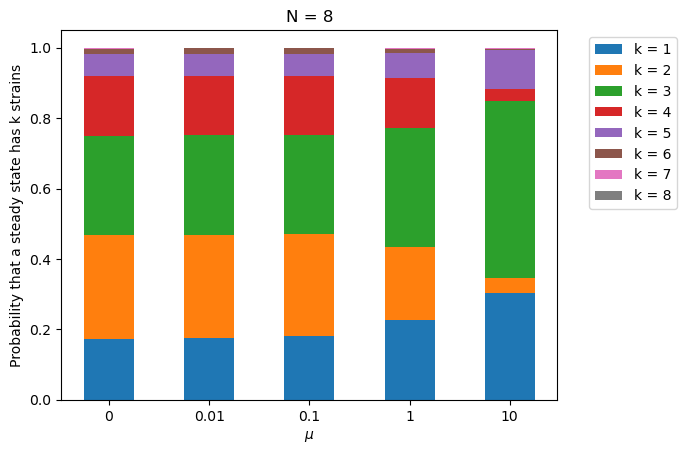

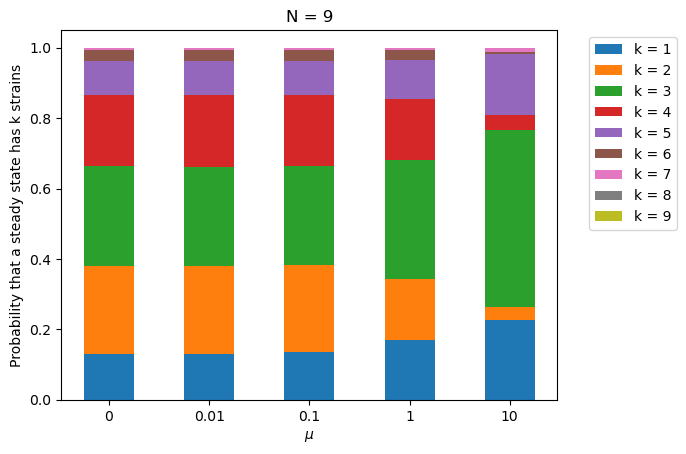

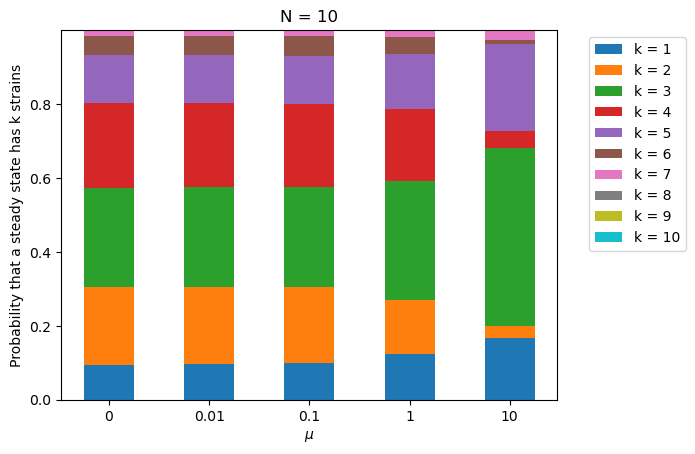

In [151]:
for N in N_values:
    plot_cumulative(N, mu_values, M, mean=0, var=1)

## Average of steady states with k strains

In [162]:
def exp_k_mu(N, mu, mean=0, var=1):
    A = generate_A(N, mean=0, var=1)
    SS = classification_test_mu(A, mu)
    exp_k_SS = np.zeros(N)
    S_Lambda = len(SS)
    for i in range(S_Lambda):
        num_non_zeros = np.count_nonzero(SS[i])
        exp_k_SS[num_non_zeros-1] += 1
    return exp_k_SS

In [163]:
def exp_mu(M, N, mu, mean=0, var=1):
    data = []
    for i in range(M):
        exp_k_SS = exp_k_mu(N, mu, mean=0, var=1)
        data.append(exp_k_SS)
    data = np.array(data)
    return data

In [166]:
def plot_exp_k(M, N_values, mu, mean=0, var=1, alpha=0.05):
    assert len(N_values) >= 5
    plot_E = []
    for N in N_values:
        data = exp_mu(M, N, mu, mean=0, var=1)
        m_k_strains = data.mean(axis=0)
        v_k_strains = data.var(axis=0)
        i = 0
        Mean = np.zeros(len(N_values)+1)
        for m, v in zip(m_k_strains, v_k_strains):
            i += 1
            m_v = v / M
            LCL, UCL = m + st.norm.isf([1 - alpha/2, alpha/2]) * np.sqrt(m_v)
            m = np.round(m, 3)
            v = np.round(v, 3)
            LCL = np.round(LCL, 3)
            UCL = np.round(UCL, 3)
            # print("Mean for %s strains: %s"%(i, m))
            # print("Variance for %s strains: %s"%(i, v))
            # print("0.95 confidence interval for %s strains: [%s, %s]"%(i, LCL, UCL))
            # print('\n')
            Mean[i-1] = m
        plot_E.append(Mean)
    plot_E = np.array(plot_E)
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    for k in range(5):
        plt.plot(N_values, plot_E[:, k], color=colors[k], label=f'k={k+1}')
    plt.ylabel('Average of steady states with k strains')
    plt.xlabel('N')
    plt.title('$\mu$=%s'%mu)
    plt.legend()
    plt.grid(True)
    plt.show()

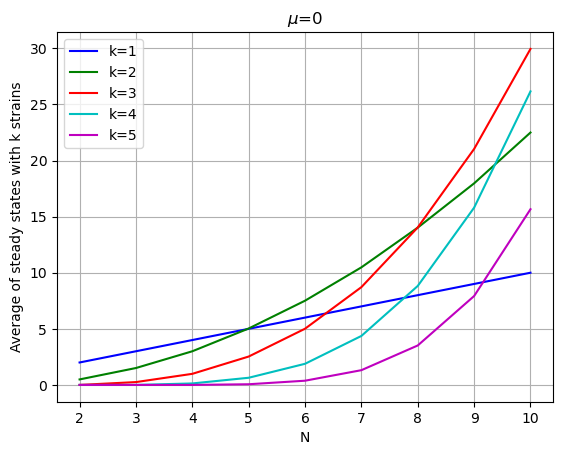

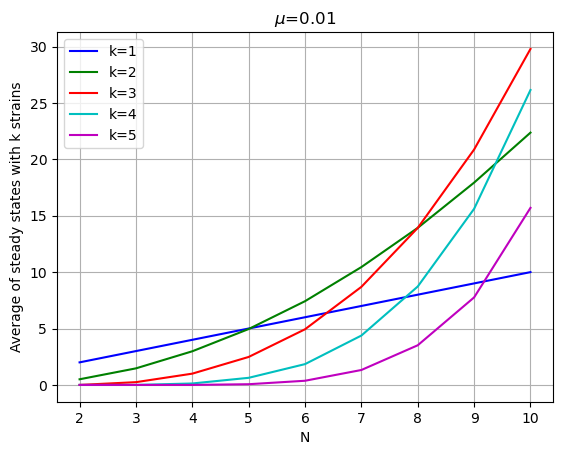

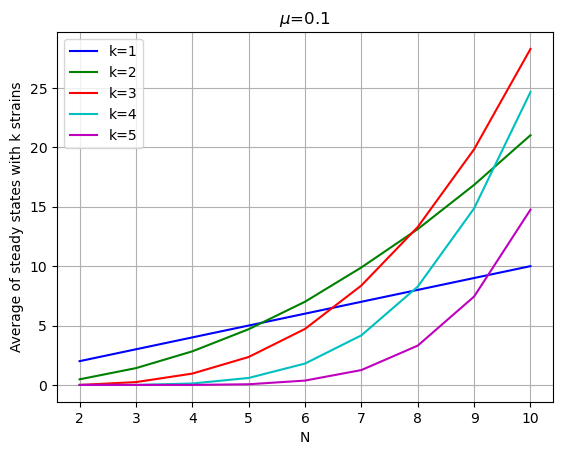

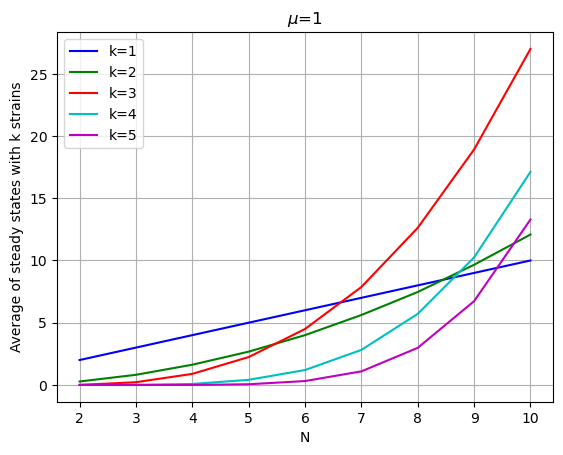

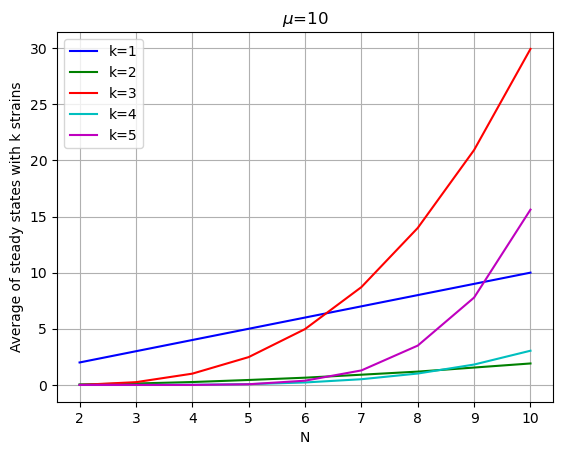

In [171]:
for mu in mu_values:
    plot_exp_k(M, N_values, mu, mean=0, var=1, alpha=0.05)

In [35]:
def plot_cumulative(N, mu_values, M, mean=0, var=1):
    data = []
    for mu in mu_values:
        prop_data = prop_mu(M, N, mu, mean, var)
        m_k_strains = prop_data.mean(axis=0)
        m_k_strains = np.insert(m_k_strains, 0, 0)
        data.append(m_k_strains)
    data = np.array(data)
    data = data.T
    fig, ax = plt.subplots()
    bar_width = 0.5
    x = np.arange(len(mu_values))
    bottom = np.zeros(len(mu_values))
    for k in range(N+1):
        ax.bar(x, data[k], bar_width, bottom=bottom, label=f'k = {k}')
        bottom += data[k]

    ax.set_xlabel('$\mu$')
    ax.set_ylabel('Probability that a steady state has k strains')
    ax.set_title(f'N = {N}')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{mu}' for mu in mu_values])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

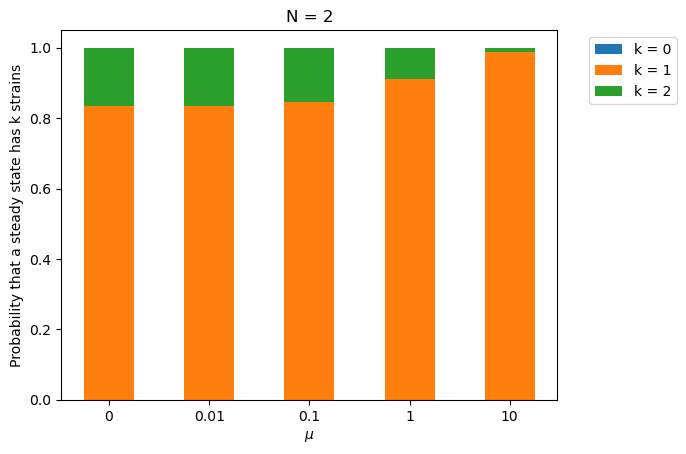

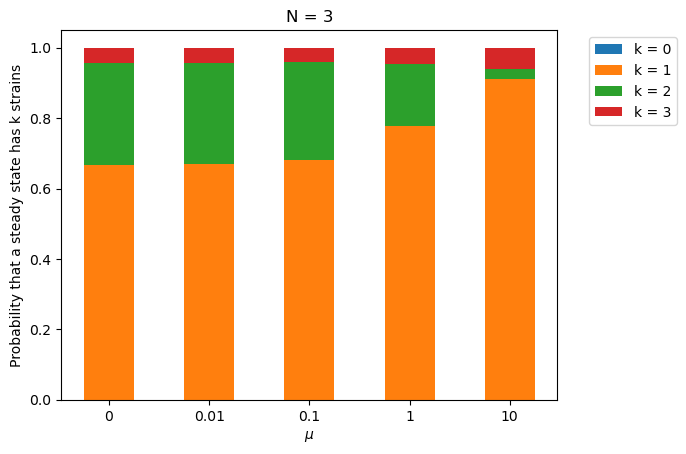

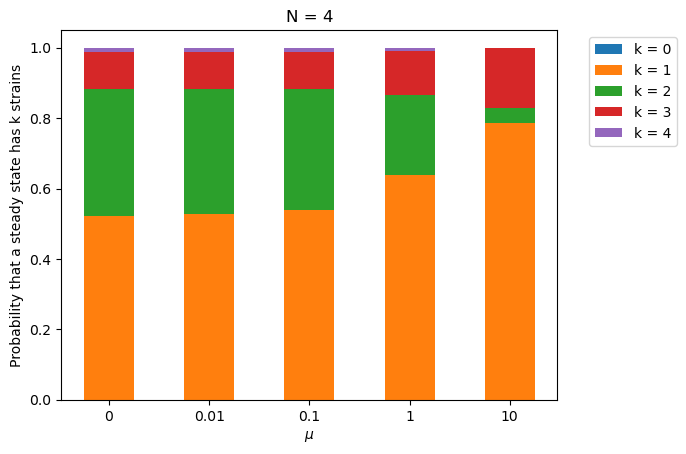

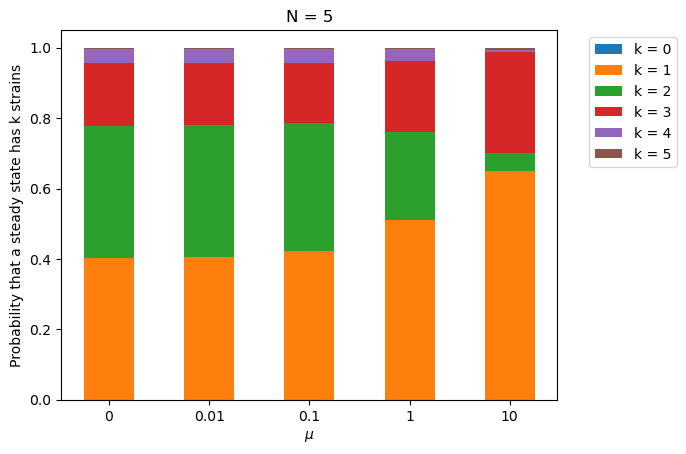

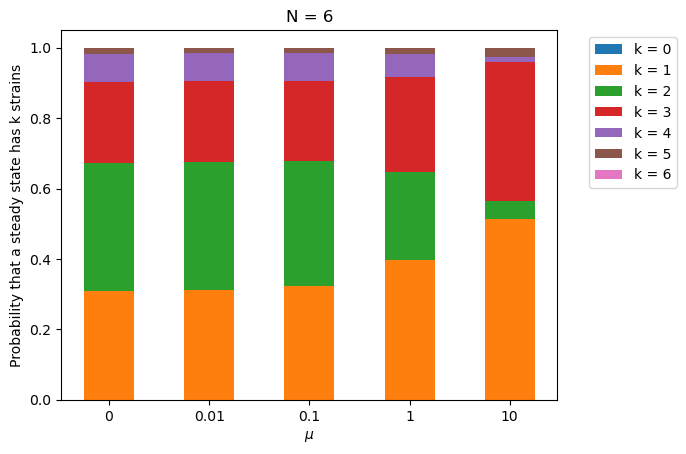

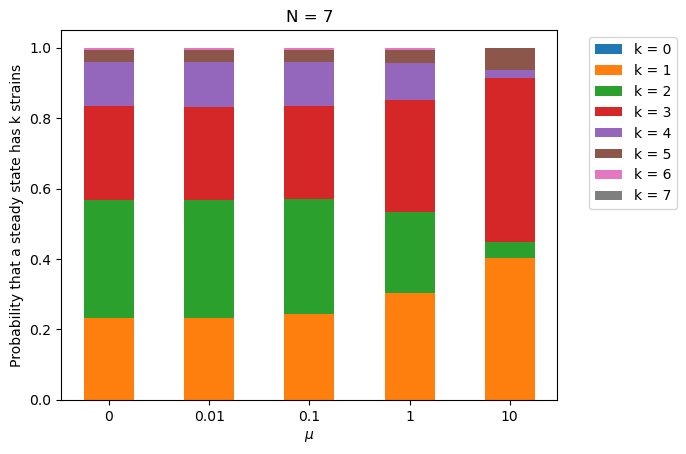

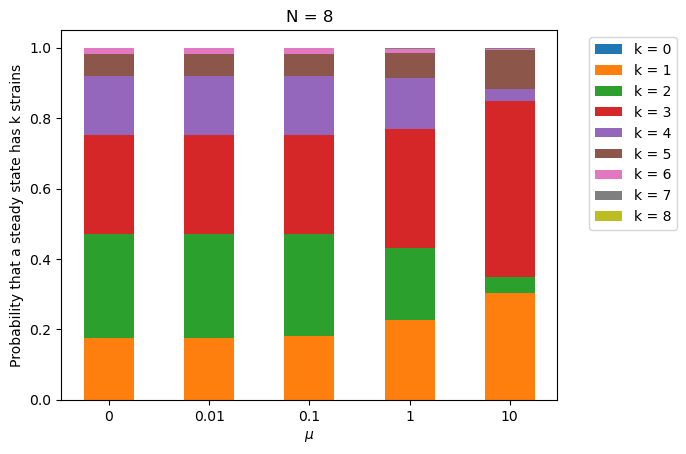

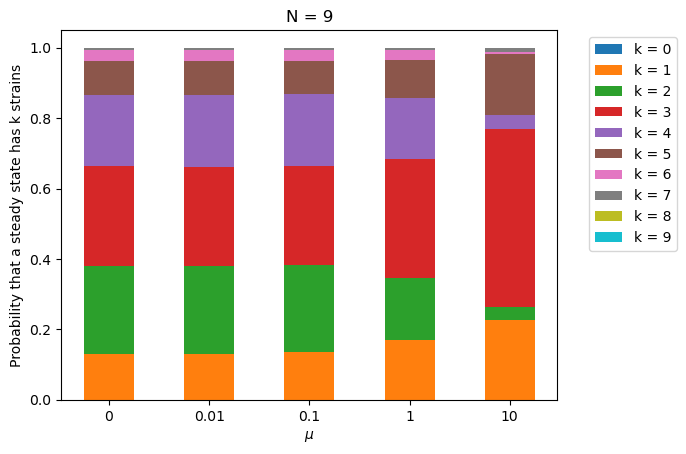

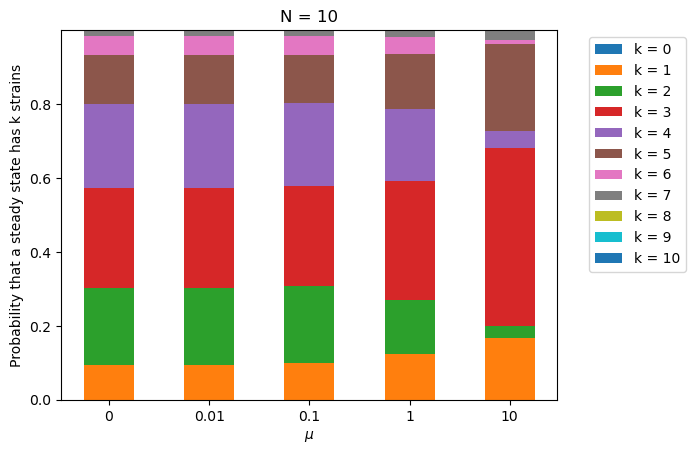

In [36]:
for N in N_values:
    plot_cumulative(N, mu_values, M, mean=0, var=1)